## Import et lecture des données

In [2]:
import os
import zipfile

zip_file_path = 'data.zip'
extract_dir = 'data_wiremind'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [3]:
# files are saved as lz4 documents. Need to install the module to handle them.
!pip install lz4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.8 MB/s eta 0:00:00


In [4]:
import lz4.frame

lz4_file_path_train = 'data_wiremind/data/train.lz4'
train_file = 'train.csv'

lz4_file_path_test = 'data_wiremind/data/test.lz4'
test_file = 'test.csv'


def extract_lz4(lz4_file_path, outfile_name):
  # Open the lz4 file for reading in binary mode
  with open(lz4_file_path, 'rb') as lz4_file:
      compressed_data = lz4_file.read()
      # Decompress the data
      decompressed_data = lz4.frame.decompress(compressed_data)

  with open(outfile_name, 'wb') as extracted_file:
      # Write the decompressed data to the extracted file
      extracted_file.write(decompressed_data)
  print(f"Contents of {lz4_file_path} extracted to {outfile_name}")

extract_lz4(lz4_file_path_train, train_file)
extract_lz4(lz4_file_path_test, test_file)

Contents of data_wiremind/data/train.lz4 extracted to train.csv
Contents of data_wiremind/data/test.lz4 extracted to test.csv


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error

import xgboost as xgb
import lightgbm as lgb
import tensorflow as tf

In [6]:
def create_dataframe_from_csv(file_name):
    df = pd.read_csv(
            file_name,
            parse_dates=['departure_date','sale_date'],
            dtype={
                'dataset_type':'category',
                'origin_station_name':'category',
                'destination_station_name':'category',
                'origin_current_public_holiday':bool,
                'origin_current_school_holiday':bool,
                'destination_current_public_holiday':bool,
                'destination_current_school_holiday':bool,
                  })
    return df

df_total = pd.concat([create_dataframe_from_csv(train_file),create_dataframe_from_csv(test_file)])

## Ajout de Features
### 1. Confinement et distance au confinement

In [7]:
df_total['is_lockdown'] =  False

lockdown1_start = pd.to_datetime('2020-03-17')
lockdown1_end = pd.to_datetime('2020-05-11')
lockdown2_start = pd.to_datetime('2020-10-30')
lockdown2_end = pd.to_datetime('2020-12-15')

df_total.loc[df_total.query("departure_date >= @lockdown1_start and departure_date < @lockdown1_end").index,'is_lockdown'] = True
df_total.loc[df_total.query("departure_date >= @lockdown2_start and departure_date < @lockdown2_end").index,'is_lockdown'] = True

In [8]:
# adding nb day before lockdown as a feature
df_total['nb_day_bf_lockdown'] = 0
df_total.loc[ df_total.query("departure_date < @ lockdown1_start").index, 'nb_day_bf_lockdown'] = \
 (lockdown1_start - df_total.loc[ df_total.query("departure_date < @ lockdown1_start").index, 'departure_date']).dt.days

df_total.loc[ df_total.query("departure_date > @ lockdown1_end and departure_date < @ lockdown2_start").index, 'nb_day_bf_lockdown'] = \
 (lockdown2_start - df_total.loc[ df_total.query("departure_date > @ lockdown1_start and departure_date < @ lockdown2_start").index, 'departure_date']).dt.days

df_total.loc[ df_total.query("departure_date >= @ lockdown2_start").index, 'nb_day_bf_lockdown'] = 0

### 2. Ajout de features précisant les départs et les lignes empruntées

In [9]:
# adding a datetime column to enhance handling
df_total['departure_datetime'] = df_total['departure_date'] + pd.to_timedelta(df_total['od_origin_time'], unit = 'm')

In [10]:
# create a line id for each origin-destination couple.
df_total['od_origin_hour'] = df_total['od_origin_time']//30 # half_hour to enhance precision
df_total['id_ligne'] =  df_total['origin_station_name'].str.cat(df_total['destination_station_name'], sep='-').astype('category')
grouped = df_total.groupby(['id_ligne','od_origin_weekday','od_origin_hour'])
df_total['id_timetable'] = grouped.ngroup().astype('category')
# id_timetable is a category to identify rows by line and departure_time range : ex: trains ag-cpe starting between 9 and 9.30 am.

## 3. Ajout du target encoding par quantile sur l'id_timetable

In [11]:
# let's try a taget encoding : code the 75% upper quantile of the demand as a value for the id_timetable category.

def target_encode_upper_quantile(df, by, on, quantile=0.75):
  df_train = df.query("dataset_type == 'training'") # we must work on train data to avoid fitting also on test data.
  upper_quantile = df_train.groupby(by)[on].quantile(quantile)
  df[f'{on}_{by}_encoding'] = df['id_timetable'].map(upper_quantile)
  return df

df_total = target_encode_upper_quantile(df_total, 'id_timetable', 'demand', quantile=0.95)

## 4. one hot encoding par ligne :

In [12]:
# Appliquer le one-hot encoding
df_one_hot = pd.get_dummies(df_total['id_ligne'], prefix='id_ligne')
df_total = pd.concat([df_total, df_one_hot], axis=1)


In [13]:
# convert date to int to ease xgboost
df_total['departure_date_n'] = df_total['departure_date'].dt.dayofyear
df_total['sale_date_n'] = df_total['sale_date'].dt.dayofyear

# Entrainement du modele lgbm

## 1. Selection des features

In [14]:
# df_total.dtypes

In [15]:
FEATURES = [
'destination_current_public_holiday',
'destination_current_school_holiday',
'destination_days_to_next_public_holiday',
'destination_days_to_next_school_holiday',
'destination_station_name',
'od_destination_time',
'od_number_of_similar_12_hours',
'od_number_of_similar_2_hours',
'od_number_of_similar_4_hours',
'od_origin_month',
'od_origin_time',
'od_origin_week',
'od_origin_weekday',
'od_origin_year',
'od_travel_time_minutes',
'origin_current_public_holiday',
'origin_current_school_holiday',
'origin_days_to_next_public_holiday',
'origin_days_to_next_school_holiday',
'origin_station_name',
'price',
'sale_day_x',
'sale_month',
'sale_week',
'sale_weekday',
'sale_year',
'nb_day_bf_lockdown',
'is_lockdown',
'od_origin_hour',
'id_ligne',
'id_timetable',
'demand_id_timetable_encoding'
       ]

TARGET = ['demand']

## 2. ajout de lag

In [16]:
# adding id_train column for ergonomy : an index on line/departure_datetime.
df_total['id_train'] = df_total.groupby(['id_ligne','departure_datetime']).ngroup()

In [17]:
# creating a mapping for lag calculation
dico = df_total.set_index(['id_train', 'sale_day_x'])['demand'].to_dict()

def demand_lag(row,dico=dico,nb_day_lag=1):
    k = (row['id_train'],row['sale_day_x']-nb_day_lag)
    if k in dico:
      return dico[k]
    return np.nan

In [18]:
for i in range(1,14):
  df_total[f'lag_{i}'] = df_total.apply(lambda row: demand_lag(row,dico,i), axis=1)
  print(f'lag_{i}')
  FEATURES += [f'lag_{i}']

lag_1
lag_2
lag_3
lag_4
lag_5
lag_6
lag_7
lag_8
lag_9
lag_10
lag_11
lag_12
lag_13


In [31]:
train = df_total.query(" dataset_type == 'training' ")

test = df_total.query(" dataset_type == 'testing' ")

TARGET = 'demand'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [32]:
# Convert input data to specific LightGBM format
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    'objective': 'regression',
    'metric': 'mse',
    'boosting_type': 'gbdt',
    'num_leaves': 47,
    'learning_rate': 0.012,
    'feature_fraction': 0.88
}
stopping_rounds = 45
early_stop = lgb.early_stopping(stopping_rounds, first_metric_only=False, verbose=True, min_delta=0.0)

# Training setup
num_round = 2500
bst = lgb.train(params, train_data, num_round, valid_sets=[train_data, test_data], callbacks=[early_stop])

# Let's predict the demand
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

# Evaluate it by rmse
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Mean Squared Error on Test Set: {rmse}')

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.095206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2386
[LightGBM] [Info] Number of data points in the train set: 632841, number of used features: 44
[LightGBM] [Info] Start training from score 3.000149
Training until validation scores don't improve for 45 rounds
Early stopping, best iteration is:
[956]	training's l2: 6.98757	valid_1's l2: 11.5176
Mean Squared Error on Test Set: 3.3937553595257897


## 3. ajout de la demande cumulée

In [35]:
cumul_demand = df_total.sort_values('sale_day_x').groupby('id_train')['demand'].cumsum()
u = pd.merge(df_total, cumul_demand, left_on=df_total.index, right_on=cumul_demand.index, suffixes=('', '_cumul') )
u['demand_cumul'] = u['demand_cumul'] - u['demand']

In [ ]:
# adding the cumulative demand for the same train over the sale period

cumul_demand = df_total.sort_values('sale_day_x').groupby('id_train')['demand_train'].cumsum()
u['result'] = u['cumulative_demand'] - u['demand']
df_total = df_total.drop(columns=['key_0'])
a = df_total.groupby(['id_train']).get_group(42) # inspect over a random group
a

In [36]:
a = u.groupby(['id_train']).get_group(3685) # inspect over a random group
a.iloc[60:,[2,-1]]

,demand,demand_cumul
594533,12,153
594534,3,165
594535,1,168
594536,0,169
594537,1,169
594538,0,170
594539,8,170
594540,9,178
594541,8,187
594542,8,195


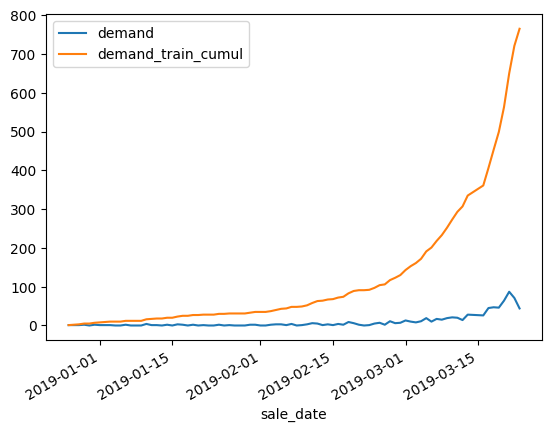

In [28]:
# Let's plot the newly created feature :
a = df_total.groupby(['id_train']).get_group(42) # inspect over a random group
ax = plt.subplot()
a.plot(x='sale_date',y='demand',ax=ax)
a.plot(x='sale_date',y='demand_train_cumul',ax=ax)
plt.show()

In [40]:
FEATURES2 = FEATURES + ['demand_cumul']
FEATURES2

['destination_current_public_holiday',
 'destination_current_school_holiday',
 'destination_days_to_next_public_holiday',
 'destination_days_to_next_school_holiday',
 'destination_station_name',
 'od_destination_time',
 'od_number_of_similar_12_hours',
 'od_number_of_similar_2_hours',
 'od_number_of_similar_4_hours',
 'od_origin_month',
 'od_origin_time',
 'od_origin_week',
 'od_origin_weekday',
 'od_origin_year',
 'od_travel_time_minutes',
 'origin_current_public_holiday',
 'origin_current_school_holiday',
 'origin_days_to_next_public_holiday',
 'origin_days_to_next_school_holiday',
 'origin_station_name',
 'price',
 'sale_day_x',
 'sale_month',
 'sale_week',
 'sale_weekday',
 'sale_year',
 'nb_day_bf_lockdown',
 'is_lockdown',
 'od_origin_hour',
 'id_ligne',
 'id_timetable',
 'demand_id_timetable_encoding',
 'lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'lag_6',
 'lag_7',
 'lag_8',
 'lag_9',
 'lag_10',
 'lag_11',
 'lag_12',
 'lag_13',
 'demand_cumul']

# Re-training du lgbm

In [41]:
train = u.query(" dataset_type == 'training' ")
# test = df_total.query(" dataset_type == 'testing' and departure_date < '2020-10-22'	")
test = u.query(" dataset_type == 'testing' ")

TARGET = 'demand'

X_train = train[FEATURES2]
y_train = train[TARGET]

X_test = test[FEATURES2]
y_test = test[TARGET]

In [42]:
# Convert input data to specific LightGBM format
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    'objective': 'regression',
    'metric': 'mse',
    'boosting_type': 'gbdt',
    'num_leaves': 49,
    'learning_rate': 0.012,
    'feature_fraction': 0.88
}
stopping_rounds = 45
early_stop = lgb.early_stopping(stopping_rounds, first_metric_only=False, verbose=True, min_delta=0.0)

# Training setup
num_round = 2500  # Nombre d'itérations (vous pouvez ajuster cela en fonction de votre problème)
bst2 = lgb.train(params, train_data, num_round, valid_sets=[train_data, test_data], callbacks=[early_stop])

# Let's predict on the whole test set.
y_pred = bst2.predict(X_test, num_iteration=bst.best_iteration)

# Evaluate it by rmse
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Mean Squared Error on Test Set: {rmse}')

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.109035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2637
[LightGBM] [Info] Number of data points in the train set: 665406, number of used features: 45
[LightGBM] [Info] Start training from score 2.961521
Training until validation scores don't improve for 45 rounds
Early stopping, best iteration is:
[1644]	training's l2: 6.14081	valid_1's l2: 10.9637
Mean Squared Error on Test Set: 3.325630490264041


On constate une amélioration de la précision du modèle.

Text(0.5, 1.0, 'LGBM feature importance')

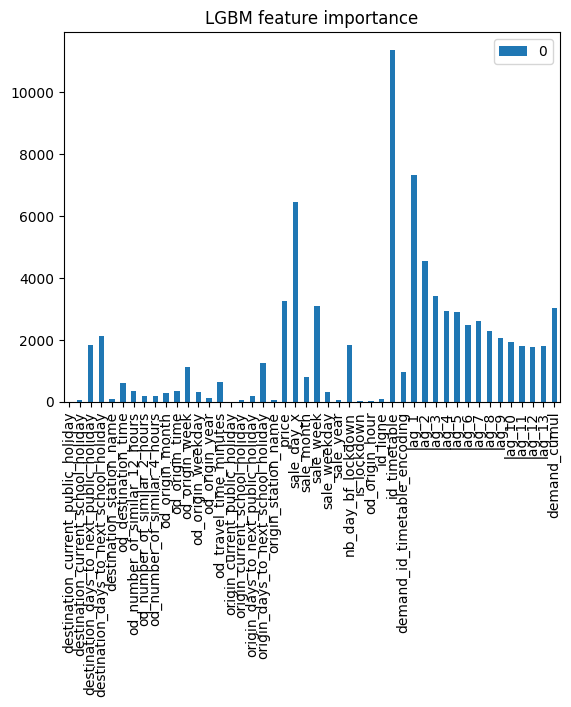

In [68]:
ax = plt.subplot()
pd.DataFrame(bst2.feature_importance(), index=bst2.feature_name()).plot(kind='bar', ax=ax)
ax.set_title('LGBM feature importance')

## I. Comparaison graphique sur quelques trains

0 1025


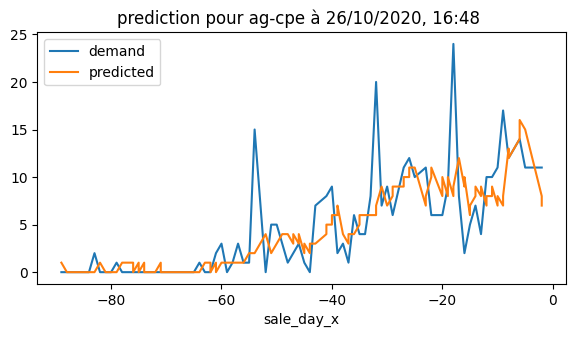

1 2866


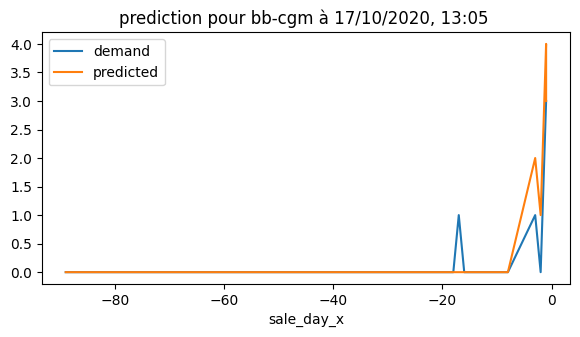

2 3845


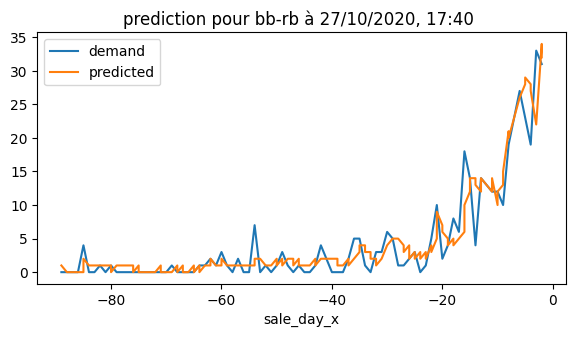

3 4226


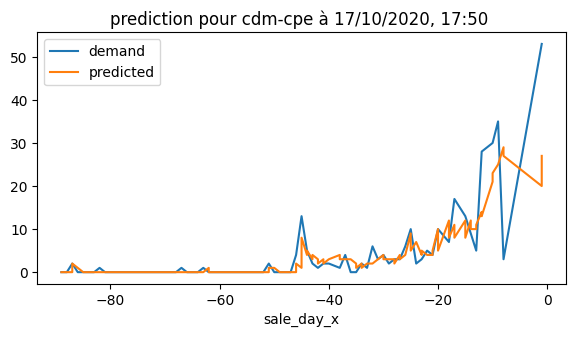

4 6888


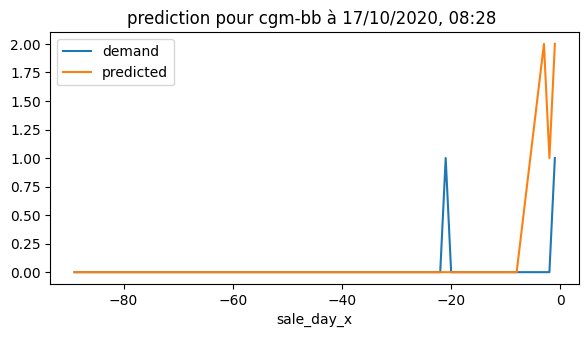

5 7839


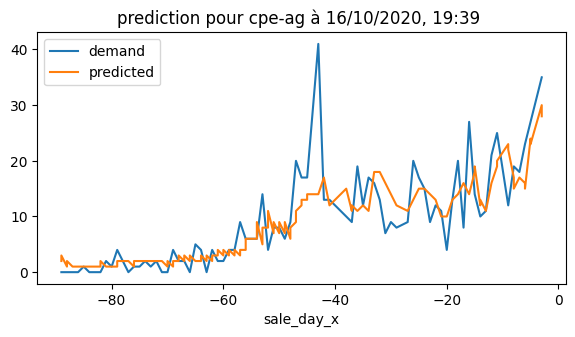

6 8293


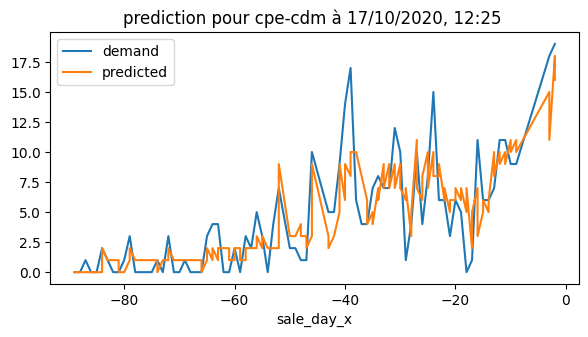

7 9546


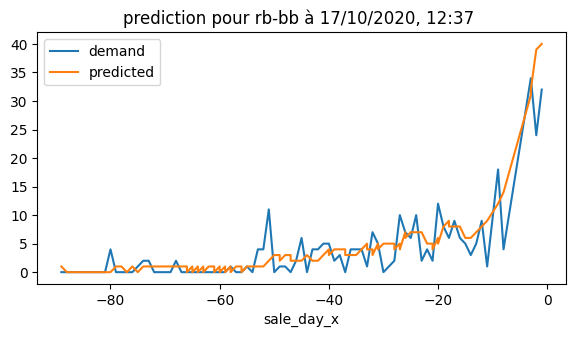

In [124]:

def compare_prediction(id_train,i):
  plt.figure(figsize=(15,15))
  u = test.query("id_train == @id_train")
  ax = plt.subplot(4,2,i+1)
  u.plot(x='sale_day_x', y='demand', ax=ax)
  X_test = u[FEATURES2]
  y_pred = bst2.predict(X_test, num_iteration=bst.best_iteration, label='prediction')
  plt.plot(u['sale_day_x'], y_pred.round())
  id_ligne = u.loc[u.index[0],'id_ligne']
  date = (u.loc[u.index[0],'departure_datetime']).strftime("%d/%m/%Y, %H:%M")
  ax.set_title(f'prediction pour {id_ligne} à {date} ')
  ax.legend(['demand','predicted'])


# for i, id_train in enumerate([1024,2861,3840,4224,6883,7838,8291,9542]):
for i, id_train in enumerate([1025,2866,3845,4226,6888,7839,8293,9546]):
  print(i, id_train)
  compare_prediction(id_train,i)
  plt.show()

## II. Optimisation de la politique de prix.

Quel prix affecter à chaque jour de vente de manière à maximiser la marge faite sur le train ? Sachant qu'un prix plus elevé diminue la demande.  
On cherche à résoudre le problème d'optimisation continu suivant :
$$
p_{optim} = \text{argmax}_{p \in \mathbb{R}^{90}} \left( \sum_{j=-89}^{0} p_j \cdot d_j(p_j) \right)
$$

Maintenant qu'on a un bon modèle de prédiction de la demande, checkons si on maximise bien le remplissage des trains et le revenu par train.
On veut choisir une politique de prix qui maximise le revenu par train sans diminuer la demande.

En python, on crée une fonction qui à un vecteur prix de dimension ~90 (nombre de jours de vente) valeurs associe sum(pj*d(pj)).

In [72]:
D = {
'ag-cpe'  : {1024, 1025, 1026, 1027, 1028, 1029, 1030},
'bb-cgm'  : {2861, 2862, 2863, 2864, 2865, 2866, 2867},
'bb-rb'  : {3840, 3841, 3842, 3843, 3844, 3845, 3846},
'cdm-cpe'  : {4224, 4225, 4226, 4227, 4228, 4229, 4230},
'cgm-bb'  : {6883, 6884, 6885, 6886, 6887, 6888, 6889},
'cpe-ag'  : {7838, 7839, 7840, 7841, 7842, 7843, 7844},
'cpe-cdm' : {8291, 8292, 8293, 8294, 8295, 8296, 8297},
'rb-bb'    : {9542, 9543, 9544, 9545, 9546, 9547, 9548},
}

In [116]:
id_train = 985
u = test.query("id_train == @id_train").copy()
v_price = u['price']

def revenue(u, v_price):
  u.loc[:,'price'] = v_price.T
  X_test = u[FEATURES]
  y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)
  return X_test['price']@y_pred

revenue(u, v_price)

22045.1056164445

In [52]:
from scipy.optimize import minimize, Bounds

In [120]:
random.seed(1996)

The maximum number of function evaluations is exceeded.
Number of iterations: 6, function evaluations: 954, CG iterations: 5, optimality: 1.56e+01, constraint violation: 0.00e+00, execution time: 2.2e+01 s.


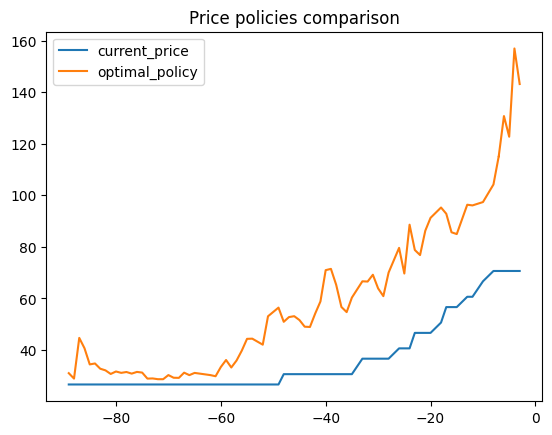

In [127]:
import random

id_train = random.choice(id_used) #  2894
u = test.query("id_train == @id_train").copy()
# u = test.query("id_train == @id_train").copy
x0 = u['price'].copy()
initial_guess = x0
boundary = Bounds(lb=0.2*min(x0)*np.ones(x0.shape), ub=8*max(x0)*np.ones(x0.shape))
result = minimize(lambda x: -revenue(u, x), initial_guess, tol=0.01, bounds=boundary, options={'maxiter':6, 'disp':True},  method='trust-constr')

xx = u['sale_day_x']
ax = plt.subplot()
plt.plot(xx,np.array(x0))
plt.plot(xx,result.x)
ax.set_title('Price policies comparison')
ax.legend(['current_price', 'optimal_policy'])
plt.show()

On obtient ainsi une proposition tarifaire qui maximise le revenu du train, selon le modèle donné.
Les données ne semblent pas suffisantes pour capter la sensibilité de la demande à une trop forte hausse. On trouve certains cas cependant où proposer des prix moins elevés que ceux pratiqués augmenterait la demande et le revenu final :

The maximum number of function evaluations is exceeded.
Number of iterations: 6, function evaluations: 1074, CG iterations: 6, optimality: 9.35e-01, constraint violation: 0.00e+00, execution time: 1.6e+01 s.


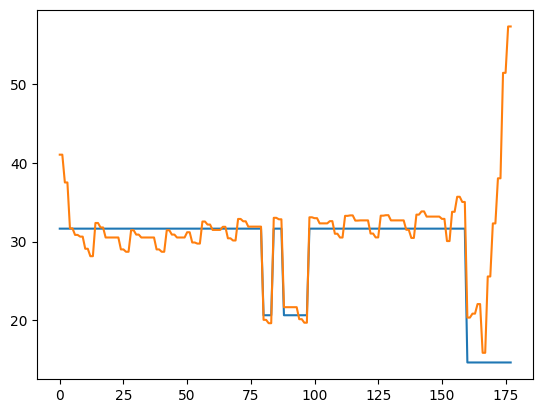

In [128]:
id_train = 2861
u = test.query("id_train == @id_train").copy()
# u = test.query("id_train == @id_train").copy
x0 = u['price'].copy()
initial_guess = x0
boundary = Bounds(lb=0.2*min(x0)*np.ones(x0.shape), ub=8*max(x0)*np.ones(x0.shape))
result = minimize(lambda x: -revenue(u, x), initial_guess, tol=0.01, bounds=boundary, options={'maxiter':6, 'disp':True},  method='trust-constr')

plt.plot(np.array(x0))
plt.plot(result.x)
plt.show()

In [129]:
id_train = 2861
u = test.query("id_train == @id_train").copy()
# u = test.query("id_train == @id_train").copy
x0 = u['price'].copy()
initial_guess = x0
result2 = minimize(lambda x: -revenue(u, x), initial_guess, tol=0.01, method='trust-constr', bounds=boundary, options={'maxiter':10, 'disp':True})

The maximum number of function evaluations is exceeded.
Number of iterations: 10, function evaluations: 1790, CG iterations: 11, optimality: 7.03e-01, constraint violation: 0.00e+00, execution time: 4.9e+01 s.


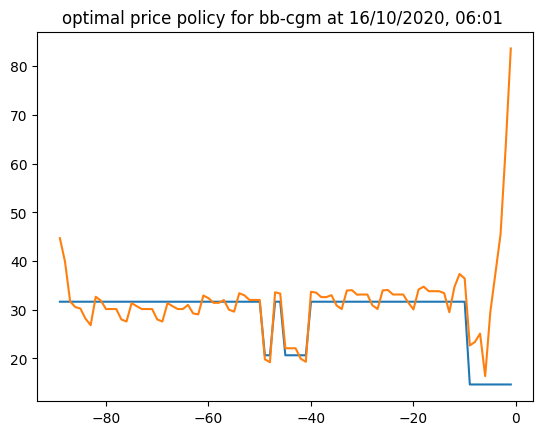

In [130]:
xx = u['sale_day_x']
plt.plot(xx,np.array(x0))
plt.plot(xx,result2.x)
id_ligne = u.loc[u.index[0],'id_ligne']
date = (u.loc[u.index[0],'departure_datetime']).strftime("%d/%m/%Y, %H:%M")
plt.title(f'optimal price policy for {id_ligne} at {date} ')
# plt.title('')
plt.show()